#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q libtiff
!pip install -q tqdm

     |████████████████████████████████| 133kB 8.0MB/s 


Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


В переменную PROJECT_DIR необходимо прописать путь к директории на Google Drive, в которую Вы загрузили zip архивы с предоставленными наборами данных.

In [3]:
PROJECT_DIR = 'Colab Notebooks/prak_nn_1_data/'

Константы, которые пригодятся в коде далее:

In [4]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')

Импорт необходимых зависимостей:

In [13]:
from pathlib import Path
from libtiff import TIFF
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
import itertools

---
### Класс Dataset

Предназначен для работы с наборами данных, хранящихся на Google Drive, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [6]:
class Dataset:

    def __init__(self, name, gdrive_dir):
        self.name = name
        self.is_loaded = False
        p = Path("/content/drive/MyDrive/" + gdrive_dir + name + '.npz') 
        if p.exists():
            print(f'Loading dataset {self.name} from npz.')
            np_obj = np.load(str(p))
            self.images = np_obj['data']
            self.labels = np_obj['labels']
            self.n_files = self.images.shape[0]
            self.is_loaded = True
            print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
  
    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

    def predprocess_data():
        self.images /= 255
        self.labels = tf.keras.utils.to_categorical(self.labels, 10)

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 6.
Label code corresponds to NORM class.


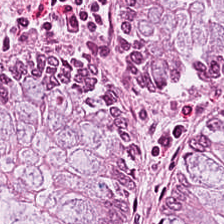

In [7]:
d_train_tiny = Dataset('train_tiny', PROJECT_DIR)

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

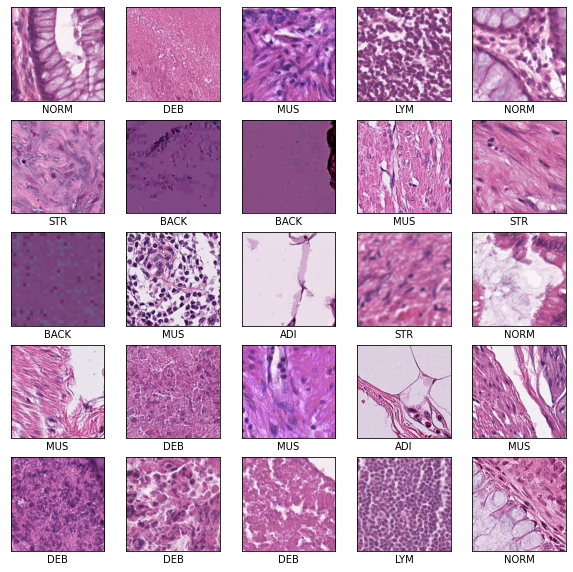

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img, lbl = d_train_tiny.random_image_with_label()
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(TISSUE_CLASSES[lbl])
plt.show()

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [9]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [15]:
class Model:

    def __init__(self):
        self.model = self.create_model()

    def save(self, name: str):
        p = Path("/content/drive/MyDrive/" + PROJECT_DIR + name) 
        self.model.save(p)
            

    def load(self, name: str):
        p = Path("/content/drive/MyDrive/" + PROJECT_DIR + name) 
        if p.exists():
            self.model = models.load_model(p)

    def train(self, dataset: Dataset):
        # Сломалось в последние дни, пока не получилось починить
        # 
        # checkpoint_path = 'training/model.{epoch:02d}.h5'
        # p = Path('/content/drive/MyDrive/' + PROJECT_DIR + checkpoint_path)
        # Create a callback that saves the model's weights
        # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=p,
        #                                                  save_weights_only=True,
        #                                                  verbose=1)

        # LBL1
        # --Остановка обучения при потере точности на валидационной выборке--
        early_stopping_callback = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                                          patience=4)     
        
        print(f'training started')

        # LBL2
        # --Валидация на части обучающей выборки в процессе обучения--
        # --Вывод метрик в процессе обучения--
        x_train, x_val, y_train, y_val = train_test_split(dataset.images, dataset.labels, test_size=0.2, random_state=1)

        self.history = self.model.fit(x_train, 
                                      y_train,
                                      batch_size=64,
                                      epochs=50,
                                      validation_data=(x_val,
                                                       y_val),
                                      shuffle=True,
                                      verbose=1,
                                      callbacks=[early_stopping_callback])
        
        print(f'training done')
        
        # LBL3
        # --Построенин графиков, визуализирующих процесс обучения
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot(self.history.history['sparse_categorical_accuracy'], 
                 label='Точность на обучающей выборке')
        plt.plot(self.history.history['val_sparse_categorical_accuracy'], 
                 label='Точность на тестовой выборке')
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Точность')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(self.history.history['loss'], 
                 label='Функция потерь на обучающей выборке')
        plt.plot(self.history.history['val_loss'], 
                 label='Функция потерь на тестовой выборке')
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Точность')
        plt.legend()


    def load_weights_from_checkpoint(self, checkpoint_path: str):
        self.model.load_weights(Path("/content/drive/MyDrive/" + PROJECT_DIR + checkpoint_path))


    def create_model(self):
        model = models.Sequential([
            layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                          input_shape=(224, 224, 3)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((4, 4)),
            layers.Dropout(0.1),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((4, 4)),
            layers.Dropout(0.1),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dropout(0.25),
            layers.Dense(784, activation='relu'),
            layers.Dropout(0.25),
            layers.Dense(256, activation='relu'),
            layers.Dense(10, activation='softmax'),
        ])

        # LBL4
        # --Уменьшение скорости обучения при большом числе эпох--
        optimizer = tf.keras.optimizers.Adam(
            tf.keras.optimizers.schedules.InverseTimeDecay(
                0.001,
                decay_steps=64 * 10,
                decay_rate=1,
                staircase=False
            )
        )

        model.compile(optimizer=optimizer,
                      loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=[tf.metrics.SparseCategoricalAccuracy()])

        return model


    def test_on_dataset(self, dataset: Dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        prediction = np.argmax(self.model(np.array([img])))
        return prediction

    
    def plot_image(self, true_label, img: np.ndarray):
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)

        predictions_array = np.reshape(self.model(np.array([img])), (10, ))
        predicted_label = np.argmax(predictions_array)
        if predicted_label == true_label:
            color = 'blue'
        else:
            color = 'red'
        
        plt.xlabel("{} {:2.0f}% ({})".format(TISSUE_CLASSES[predicted_label],
                                             100*np.max(predictions_array),
                                             TISSUE_CLASSES[true_label]),
                                             color=color)
        
    
    def plot_value_array(self, true_label, img: np.ndarray):
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])

        predictions_array = np.reshape(self.model(np.array([img])), (10, ))
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)

        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')

    

    # LBL5
    # --Оценка качества модели на отдельном изображении--
    def plot_prediction(self, true_label, img: np.ndarray):
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        self.plot_image(true_label, img)
        plt.subplot(1,2,2)
        self.plot_value_array(true_label, img)


    def summary(self):
        return self.model.summary()

    
    # LBL6
    # --Матрица смежности модели--
    def plot_confusion_matrix(self, dataset: Dataset):
        predicted_labels = np.array(self.test_on_dataset(dataset))
        cm = confusion_matrix(dataset.labels, predicted_labels)

        print('Confusion matrix, without normalization')
        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.cool)
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(TISSUE_CLASSES))
        plt.xticks(tick_marks, TISSUE_CLASSES, rotation=45)
        plt.yticks(tick_marks, TISSUE_CLASSES)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

In [11]:
model = Model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 64)        3

---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [12]:
d_train = Dataset('train', PROJECT_DIR)
d_test = Dataset('test', PROJECT_DIR)

Loading dataset train from npz.
Done. Dataset train consists of 18000 images.
Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


Пример обучения модели (5 эпох)

training started
Epoch 1/50
225/225 [==============================] - 114s 466ms/step - loss: 3.2927 - sparse_categorical_accuracy: 0.1502 - val_loss: 1.6342 - val_sparse_categorical_accuracy: 0.3983
Epoch 2/50
225/225 [==============================] - 105s 467ms/step - loss: 1.3896 - sparse_categorical_accuracy: 0.4770 - val_loss: 0.9411 - val_sparse_categorical_accuracy: 0.6497
Epoch 3/50
225/225 [==============================] - 105s 469ms/step - loss: 0.9463 - sparse_categorical_accuracy: 0.6386 - val_loss: 0.7504 - val_sparse_categorical_accuracy: 0.7286
Epoch 4/50
225/225 [==============================] - 105s 468ms/step - loss: 0.7351 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.5984 - val_sparse_categorical_accuracy: 0.7819
Epoch 5/50
225/225 [==============================] - 106s 469ms/step - loss: 0.6000 - sparse_categorical_accuracy: 0.7828 - val_loss: 0.5242 - val_sparse_categorical_accuracy: 0.8200
Epoch 6/50
225/225 [==============================] - 106s 470m

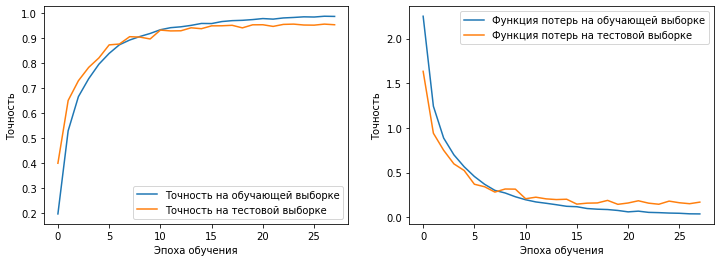

In [16]:
model = Model()
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('models/model_best.h5')
else:
    model.load('models/model_best.h5')

Пример тестирования модели на части набора данных:

In [18]:
# evaluating model on 10% of test dataset
model = Model()
model.load('models/model_best.h5')

pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')


metrics for 10% of test:
	 accuracy 0.9867:
	 balanced accuracy 0.9867:


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Пример классификации изображения с визуализацией последнего слоя сети

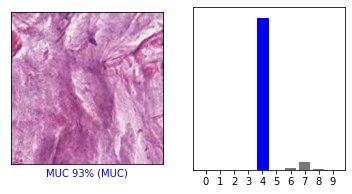

In [50]:
model = Model()
model.load('models/model_best.h5')

img, lbl = d_test.random_image_with_label()

model.plot_prediction(lbl, img)

Пример тестирования модели на полном наборе данных:

In [17]:
# evaluating model on full test dataset (may take time)
d_test = Dataset('test', PROJECT_DIR)

model = Model()
model.load('models/model_best.h5')

if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

Loading dataset test from npz.
Done. Dataset test consists of 4500 images.



metrics for test:
	 accuracy 0.9509:
	 balanced accuracy 0.9509:


Построение матрицы смежности

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.



Confusion matrix, without normalization
[[ 9  0  1  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  1  1]
 [ 0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  8  0  0  1  1]
 [ 0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  1  0  9  0  0]
 [ 0  0  0  0  0  1  0  9  0]
 [ 0  0  0  0  1  0  0  0  9]]


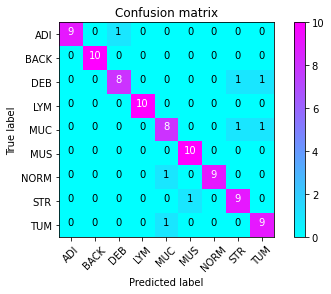

In [51]:
model = Model()
test = Dataset('test_tiny', PROJECT_DIR)
model.load('models/model_best.h5')
model.plot_confusion_matrix(test)

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [52]:
final_model = Model()
final_model.load('models/model_best.h5')
d_test_tiny = Dataset('test_tiny', PROJECT_DIR)
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.



metrics for test-tiny:
	 accuracy 0.9111:
	 balanced accuracy 0.9111:


Отмонтировать Google Drive.

In [18]:
drive.flush_and_unmount()